# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/456

Instituto de Computação - Unicamp 2021

**Membros** <br>
André de Souza Gonçalves <br>
Victor Teodoro Goraieb <br>
Vitor Anastácio 


In [2]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [ ]:
#from google.colab import files
#uploaded = files.upload()

Saving doctor-fees-train.csv to doctor-fees-train.csv


In [ ]:
try:
  train = pd.read_csv('./doctor-fees-train.csv')
except:
  train = pd.read_csv('/content/doctor-fees-train.csv')
  
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [ ]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [ ]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [ ]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [ ]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


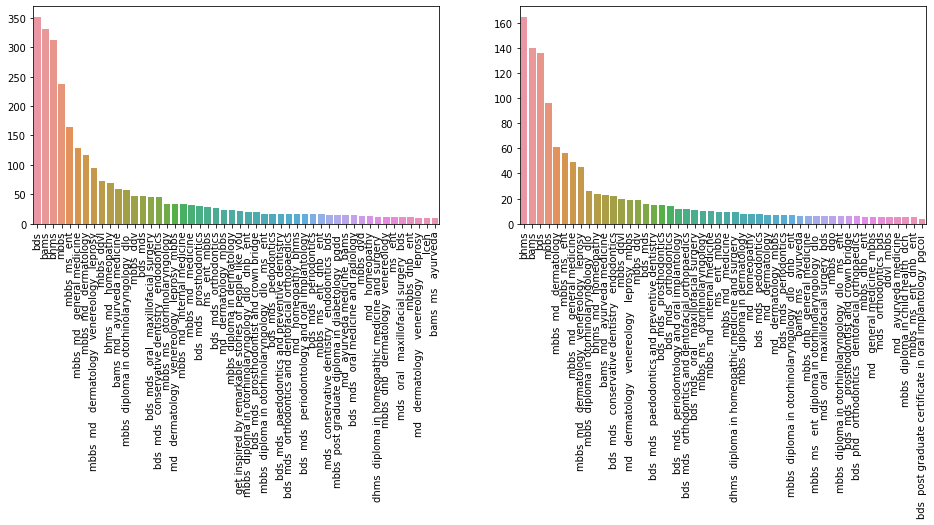

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


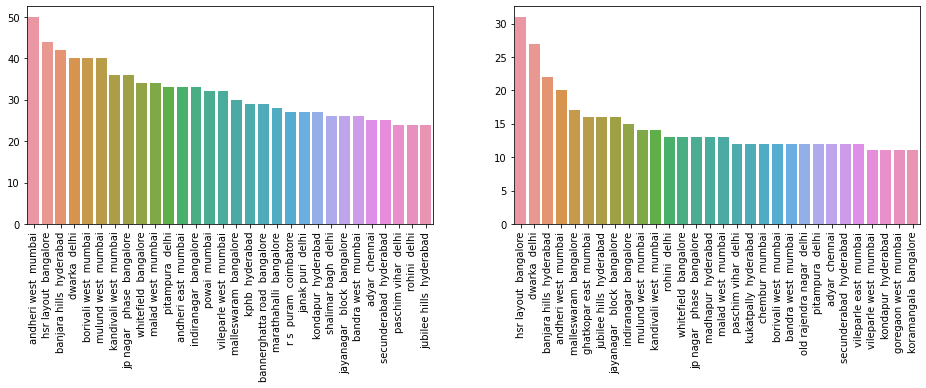

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


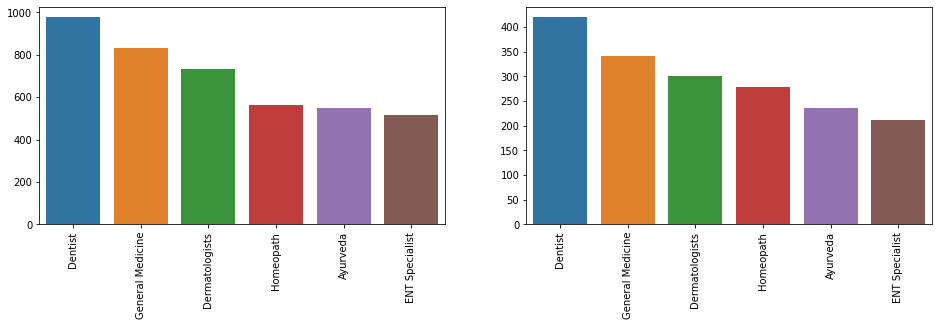

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [ ]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [ ]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [ ]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSearch, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [ ]:
np.random.seed(1082141)
sns.set()

In [4]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Utilizaremos o *Mean Squared Error* (MSE) para avaliar qual dos modelos avaliados possuem o menor valor de erro para o conjunto de validação.

In [ ]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

Utilizaremos o GridSearch variando tanto o valor de C quanto o kernel utilizado pelo SVR.

In [ ]:
C_range = np.logspace(-2, 2, 3)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=C_range, kernel=kernels)
param_grid

{'C': array([1.e-02, 1.e+00, 1.e+02]),
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [ ]:
svr = SVR(epsilon=0.1)
grid = GridSearchCV(svr, param_grid, cv=2, scoring=mse,verbose=5)
grid.fit(train_e, ye_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. C=0.01, kernel=linear, score=-0.866, total=   0.4s
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .............. C=0.01, kernel=linear, score=-0.963, total=   0.4s
[CV] C=0.01, kernel=poly .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] ................ C=0.01, kernel=poly, score=-0.963, total=   0.4s
[CV] C=0.01, kernel=poly .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] ................ C=0.01, kernel=poly, score=-1.027, total=   0.5s
[CV] C=0.01, kernel=rbf ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV] ................. C=0.01, kernel=rbf, score=-0.906, total=   0.5s
[CV] C=0.01, kernel=rbf ..............................................
[CV] ................. C=0.01, kernel=rbf, score=-1.001, total=   0.5s
[CV] C=0.01, kernel=sigmoid ..........................................
[CV] ............. C=0.01, kernel=sigmoid, score=-0.913, total=   0.6s
[CV] C=0.01, kernel=sigmoid ..........................................
[CV] ............. C=0.01, kernel=sigmoid, score=-1.002, total=   0.6s
[CV] C=1.0, kernel=linear ............................................
[CV] ............... C=1.0, kernel=linear, score=-0.920, total=   0.7s
[CV] C=1.0, kernel=linear ............................................
[CV] ............... C=1.0, kernel=linear, score=-0.972, total=   0.7s
[CV] C=1.0, kernel=poly ..............................................
[CV] ................. C=1.0, kernel=poly, score=-2.777, total=   0.6s
[CV] C=1.0, kernel=poly ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e+00, 1.e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=5)

O resultado de MSE obtido para cada combinação de C e kernel pode ser visto na tabela abaixo.

In [ ]:
svr_df = pd.DataFrame(grid.cv_results_['params'])
svr_df['score'] = grid.cv_results_['mean_test_score']
svr_df

,C,kernel,score
0,0.01,linear,-9.142895e-01
1,0.01,poly,-9.947456e-01
2,0.01,rbf,-9.536106e-01
3,0.01,sigmoid,-9.575667e-01
4,1.00,linear,-9.460304e-01
5,1.00,poly,-1.879118e+00
6,1.00,rbf,-8.895715e-01
7,1.00,sigmoid,-6.391731e+02
8,100.00,linear,-9.649485e-01
9,100.00,poly,-2.298941e+01


Com isso, temos que o kernel RBF com C = 1 foi o melhor dentre os modelos

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-0.8895714948603245
{'C': 1.0, 'kernel': 'rbf'}
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Atulizaremos a função baixo para treinar um determinado modelo, predizer o seu resultado para o conjunto de teste e retornar o MSE obtido.

In [ ]:
def calculate_regressor_mse(model):
  
  model.fit(train_e, ye_train)
  y_pred = model.predict(test_e)
  return mean_squared_error(ye_test, y_pred)

Utilizando o melhor modelo obtido pelo GridSearch, obteve-se um valor de MSE de 0.8.

In [ ]:
calculate_regressor_mse(grid.best_estimator_)

0.8038962243450666

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

Agora, compararemos os resultados com o melhor SVR obtido com GridSearch com modelos de regressão linear, Decison Trees e Random Forest. 

In [ ]:
from sklearn.linear_model import LinearRegression
calculate_regressor_mse(LinearRegression())

0.8273587653494651

In [ ]:
from sklearn.tree import DecisionTreeRegressor
calculate_regressor_mse(DecisionTreeRegressor(random_state = 0))

1.3603286594431883

In [ ]:
from sklearn.ensemble import RandomForestRegressor
calculate_regressor_mse(RandomForestRegressor(random_state=0))

0.9199613877780319

Dentre os três novos modelos de regressão avaliados, a regressão linear foi a melhor. Porém, ainda assim o SVR com kernel RBF e C = 1 obteve um MSE melhor.

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [5]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



In [6]:
x_train

array([[ 0.,  1., 11., ...,  6.,  0.,  0.],
       [ 0.,  0.,  0., ..., 15.,  4.,  0.],
       [ 0.,  0.,  6., ...,  9.,  1.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  2., ...,  1.,  0.,  0.],
       [ 0.,  0.,  5., ...,  0.,  0.,  0.]])

### 256 primeiras amostras no conjunto de treinamento

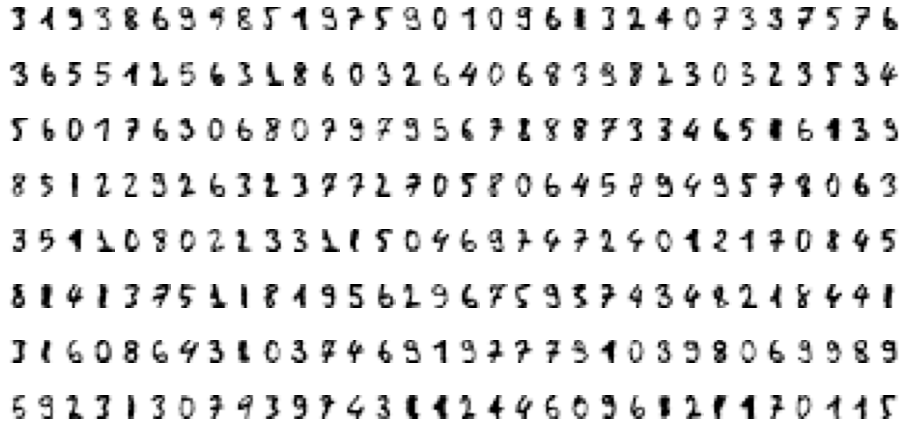

In [ ]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


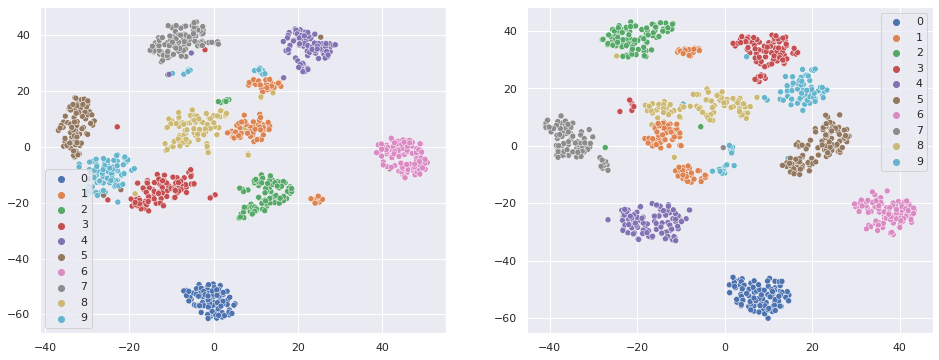

In [ ]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


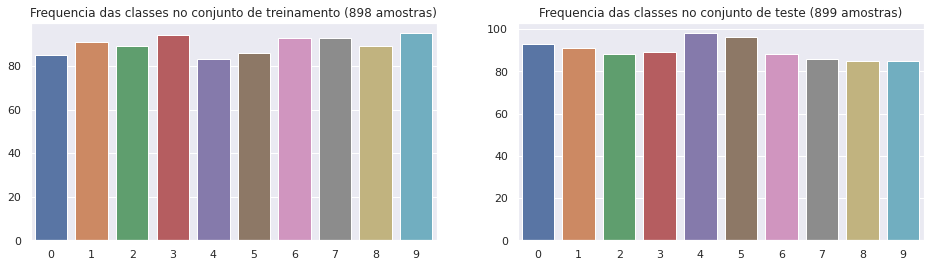

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

In [ ]:
from sklearn.svm import SVC
linear_svm = SVC(kernel='linear')

Neste momento, analisaremos mais opções de C e faremos Cross Validation com 10 folds.

In [ ]:
C_range = np.logspace(-3, 3, 10)
param_grid = dict(C=C_range)
param_grid

{'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])}

In [ ]:
grid = GridSearchCV(linear_svm, param_grid, cv=10, scoring='balanced_accuracy',verbose=5)
grid.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=1.000, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.978, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.965, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.956, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.989, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.957, total=   0.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. C=0.001, score=0.968, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.978, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.976, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.990, total=   0.0s
[CV] C=0.004641588833612777 ..........................................
[CV] .............. C=0.004641588833612777, score=0.989, total=   0.0s
[CV] C=0.004641588833612777 ..........................................
[CV] .............. C=0.004641588833612777, score=0.965, total=   0.0s
[CV] C=0.004641588833612777 ..........................................
[CV] .............. C=0.004641588833612777, score=0.956, total=   0.0s
[CV] C=0.004641588833612777 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=5)

Com isso, obteu-se o melhor SVC linear com C igual a 0.021.

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

0.97675
SVC(C=0.021544346900318832, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

Treinando o melhor SVC encontrando com o conjunto de treino e avaliando a acurácia balanceada com o conjunto de teste.

In [ ]:
best_linear_svc = grid.best_estimator_
best_linear_svc.fit(x_train, y_train)
y_test_pred = best_linear_svc.predict(x_test)

In [ ]:
print(balanced_accuracy_score(y_test_pred, y_test))

0.9736686072074507


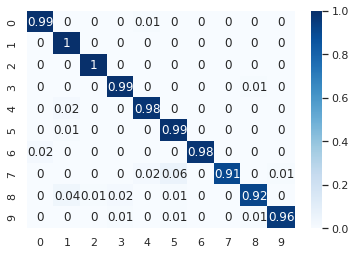

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test_pred), normalize='true').round(2), cmap='Blues', annot=True)

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [ ]:
from sklearn.svm import SVC
rbf_svm = SVC(kernel='rbf')

Para o GridSearch, testaremos as combinações de C e de gamma do kernel RBF.

In [ ]:
C_range = np.logspace(-3, 3, 4)
gamma_range = np.logspace(-3, 3, 4)
param_grid = dict(C=C_range, gamma=gamma_range)
param_grid

{'C': array([1.e-03, 1.e-01, 1.e+01, 1.e+03]),
 'gamma': array([1.e-03, 1.e-01, 1.e+01, 1.e+03])}

In [ ]:
grid = GridSearchCV(rbf_svm, param_grid, cv=10, scoring='balanced_accuracy',verbose=5)
grid.fit(x_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.189, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.189, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.189, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.167, total=   0.2s
[CV] C=0.001, gamma=0.001 ............................................
[CV] ................ C=0.001, gamma=0.001, score=0.178, total=   0.2s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.100, total=   0.2s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   24.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-01, 1.e+01, 1.e+03]),
                         'gamma': array([1.e-03, 1.e-01, 1.e+01, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=5)

A melhor combinação de C e gamma foram de C = 10 e gamma = 0.001.

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

0.9891111111111112
SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

Dado os valores de C e gamma obtidos anteriormente, faremos um RandomSearch em torno desses valores com o objetivo de encontrar alguma combinação nova de C e gamma que possa obter resultados melhores no conjunto de treino.

In [ ]:
C_range = np.logspace(0, 3, 8)
gamma_range = np.logspace(-4, -2, 8)
param_dist = dict(gamma=gamma_range, C=C_range)
param_dist

{'C': array([   1.        ,    2.6826958 ,    7.19685673,   19.30697729,
          51.79474679,  138.94954944,  372.75937203, 1000.        ]),
 'gamma': array([0.0001    , 0.00019307, 0.00037276, 0.00071969, 0.0013895 ,
        0.0026827 , 0.00517947, 0.01      ])}

In [ ]:
rand = RandomizedSearchCV(rbf_svm, param_dist, cv=10, scoring='balanced_accuracy', n_iter=10, random_state=5)
rand.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([   1.        ,    2.6826958 ,    7.19685673,   19.30697729,
         51.79474679,  138.94954944,  372.75937203, 1000.        ]),
                                        'gamma': array([0.0001    , 0.00019307, 0.00037276, 0.00071969, 0.0013895 ,
       0.0026827 , 0.00517947, 0.01      ])},
                   pre_dispatch='2*n_jobs', random_state=5, refit=True,
                   return_train_score=False, sco

In [ ]:
print(rand.best_score_)
print(rand.best_estimator_)

0.9902222222222221
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0013894954943731374,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

Avaliando a acurácia balanceada e matriz de confusão relattiva para o melhor modelo encontrado com GridSearch.

In [ ]:
best_rbf_svm_grid = grid.best_estimator_
best_rbf_svm_grid.fit(x_train, y_train)
y_test_pred = best_rbf_svm_grid.predict(x_test)

In [ ]:
print(balanced_accuracy_score(y_test_pred, y_test))

0.9866579315276361


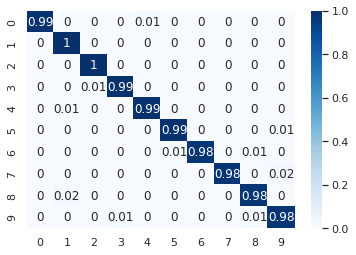

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test_pred), normalize='true').round(2), cmap='Blues', annot=True)

Avaliando a acurácia balanceada e matriz de confusão relattiva para o melhor modelo encontrado com RandomSearch.

In [ ]:
best_rbf_svm_rand = rand.best_estimator_
best_rbf_svm_rand.fit(x_train, y_train)
y_test_pred = best_rbf_svm_rand.predict(x_test)

In [ ]:
print(balanced_accuracy_score(y_test_pred, y_test))

0.987709190408094


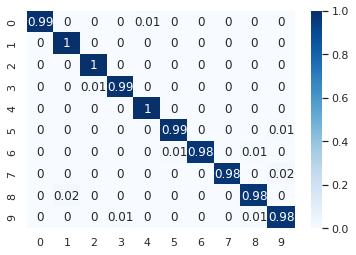

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test_pred), normalize='true').round(2), cmap='Blues', annot=True)

Como conclusão, podemos perceber que os dois modelos de classificação utilizando SVC com GridSearch e RandomSearch para idetificação dos melhores hiperparâmetros obtiveram ótimos resultados. O melhor modelo encontrado utilizando RandomSearch teve resultados levemente melhores que o melhor encontrado com GriSearch, tendo uma acurácia balanceada de 0.990 e 0.989 respectivamente para o conjunto de validação da validação cruzada e 0.987 contra 0.986 para o conjuto de teste.

Percebe-se portanto, que pode ser uma boa prática utilizar o GridSearch para uma busca mais espaçada entre os hiperparâmetros com um posterior refino dos mesmos utilizando RandomSearch.